In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


sns.set()
%matplotlib inline

In [11]:
files = [file for file in os.listdir('data/') if file[-4:] == 'xlsx']

df = pd.DataFrame()

for file in files:
    df_temp = pd.read_excel(f'data/{file}', usecols="A, B, D, F, H, I, K, N")
    df = df.append(df_temp)

# Преобразование данных

In [12]:
df.columns = [
    'date', 'patient_ID', 'sex', 'CODE_SERVER', 'COUNT_SERVER', 'PAYM',
    'MKB10', 'MKB10_1'
]

In [13]:
# Удаляем строки с пустыми диагнозами
df.dropna(subset=['MKB10', 'MKB10_1', 'sex'], inplace=True)

In [14]:
# Берем только числа из столбца "Кол-во услог"
df = df[df.COUNT_SERVER.apply(lambda x: x[0].isdigit())]

In [15]:
# Преобразуем типы
df.date = df.date.astype('datetime64[ns]')
df.patient_ID = df.patient_ID.astype(np.uint64)
df.sex = df.sex.astype(int)
df.COUNT_SERVER = df.COUNT_SERVER.astype(np.float32)
df.COUNT_SERVER = df.COUNT_SERVER.astype(np.uint16)
df.PAYM = df.PAYM.astype(np.float32)

df['month'] = df.date.dt.month
df['day'] = df.date.dt.day

In [16]:
# Кодируем категориальные данные в ранжированные данные
MKB10_enc = OrdinalEncoder()
df['MKB10_code'] = MKB10_enc.fit_transform(df[['MKB10']])

MKB10_1_enc = OrdinalEncoder()
df['MKB10_1_code'] = MKB10_1_enc.fit_transform(df[['MKB10_1']])

CODE_SERVER_enc = OrdinalEncoder()
df['CODE_SERVER_code'] = CODE_SERVER_enc.fit_transform(df[['CODE_SERVER'
                                                           ]].astype(str))

In [17]:
# Найти оригинальное значение диагноза
MKB10_enc.inverse_transform(df[['MKB10_code']])
MKB10_1_enc.inverse_transform(df[['MKB10_code']])
CODE_SERVER_enc.inverse_transform(df[['CODE_SERVER_code']])

array([['1120001'],
       ['2080017'],
       ['2080075'],
       ...,
       ['1151003'],
       ['1001004'],
       ['1140005']], dtype=object)

In [18]:
df.drop(['date', 'MKB10', 'MKB10_1', 'CODE_SERVER'], inplace=True, axis=1)

In [19]:
df.describe()

,patient_ID,sex,COUNT_SERVER,PAYM,month,day,MKB10_code,MKB10_1_code,CODE_SERVER_code
count,1.500659e+06,1.500659e+06,1.500659e+06,1.500659e+06,1.500659e+06,1.500659e+06,1.500659e+06,1.500659e+06,1.500659e+06
mean,3.294480e+06,6.401548e-01,1.193116e+00,2.048020e+03,4.946889e+00,1.615157e+01,2.550708e+03,3.996208e+04,1.138882e+03
std,1.369103e+06,4.799550e-01,1.783363e+00,9.844341e+03,8.287866e-01,8.712659e+00,1.134858e+03,2.021423e+04,1.173959e+03
min,1.150188e+06,0.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.151779e+06,0.000000e+00,1.000000e+00,7.500000e+02,4.000000e+00,8.000000e+00,1.868000e+03,2.443500e+04,1.730000e+02
50%,3.053649e+06,1.000000e+00,1.000000e+00,1.411000e+03,5.000000e+00,1.700000e+01,2.252000e+03,3.912500e+04,6.740000e+02
75%,4.841609e+06,1.000000e+00,1.000000e+00,1.847000e+03,6.000000e+00,2.400000e+01,3.483000e+03,5.657000e+04,1.926000e+03
max,5.526715e+06,1.000000e+00,2.090000e+02,5.518200e+05,6.000000e+00,3.100000e+01,5.078000e+03,7.505000e+04,4.865000e+03


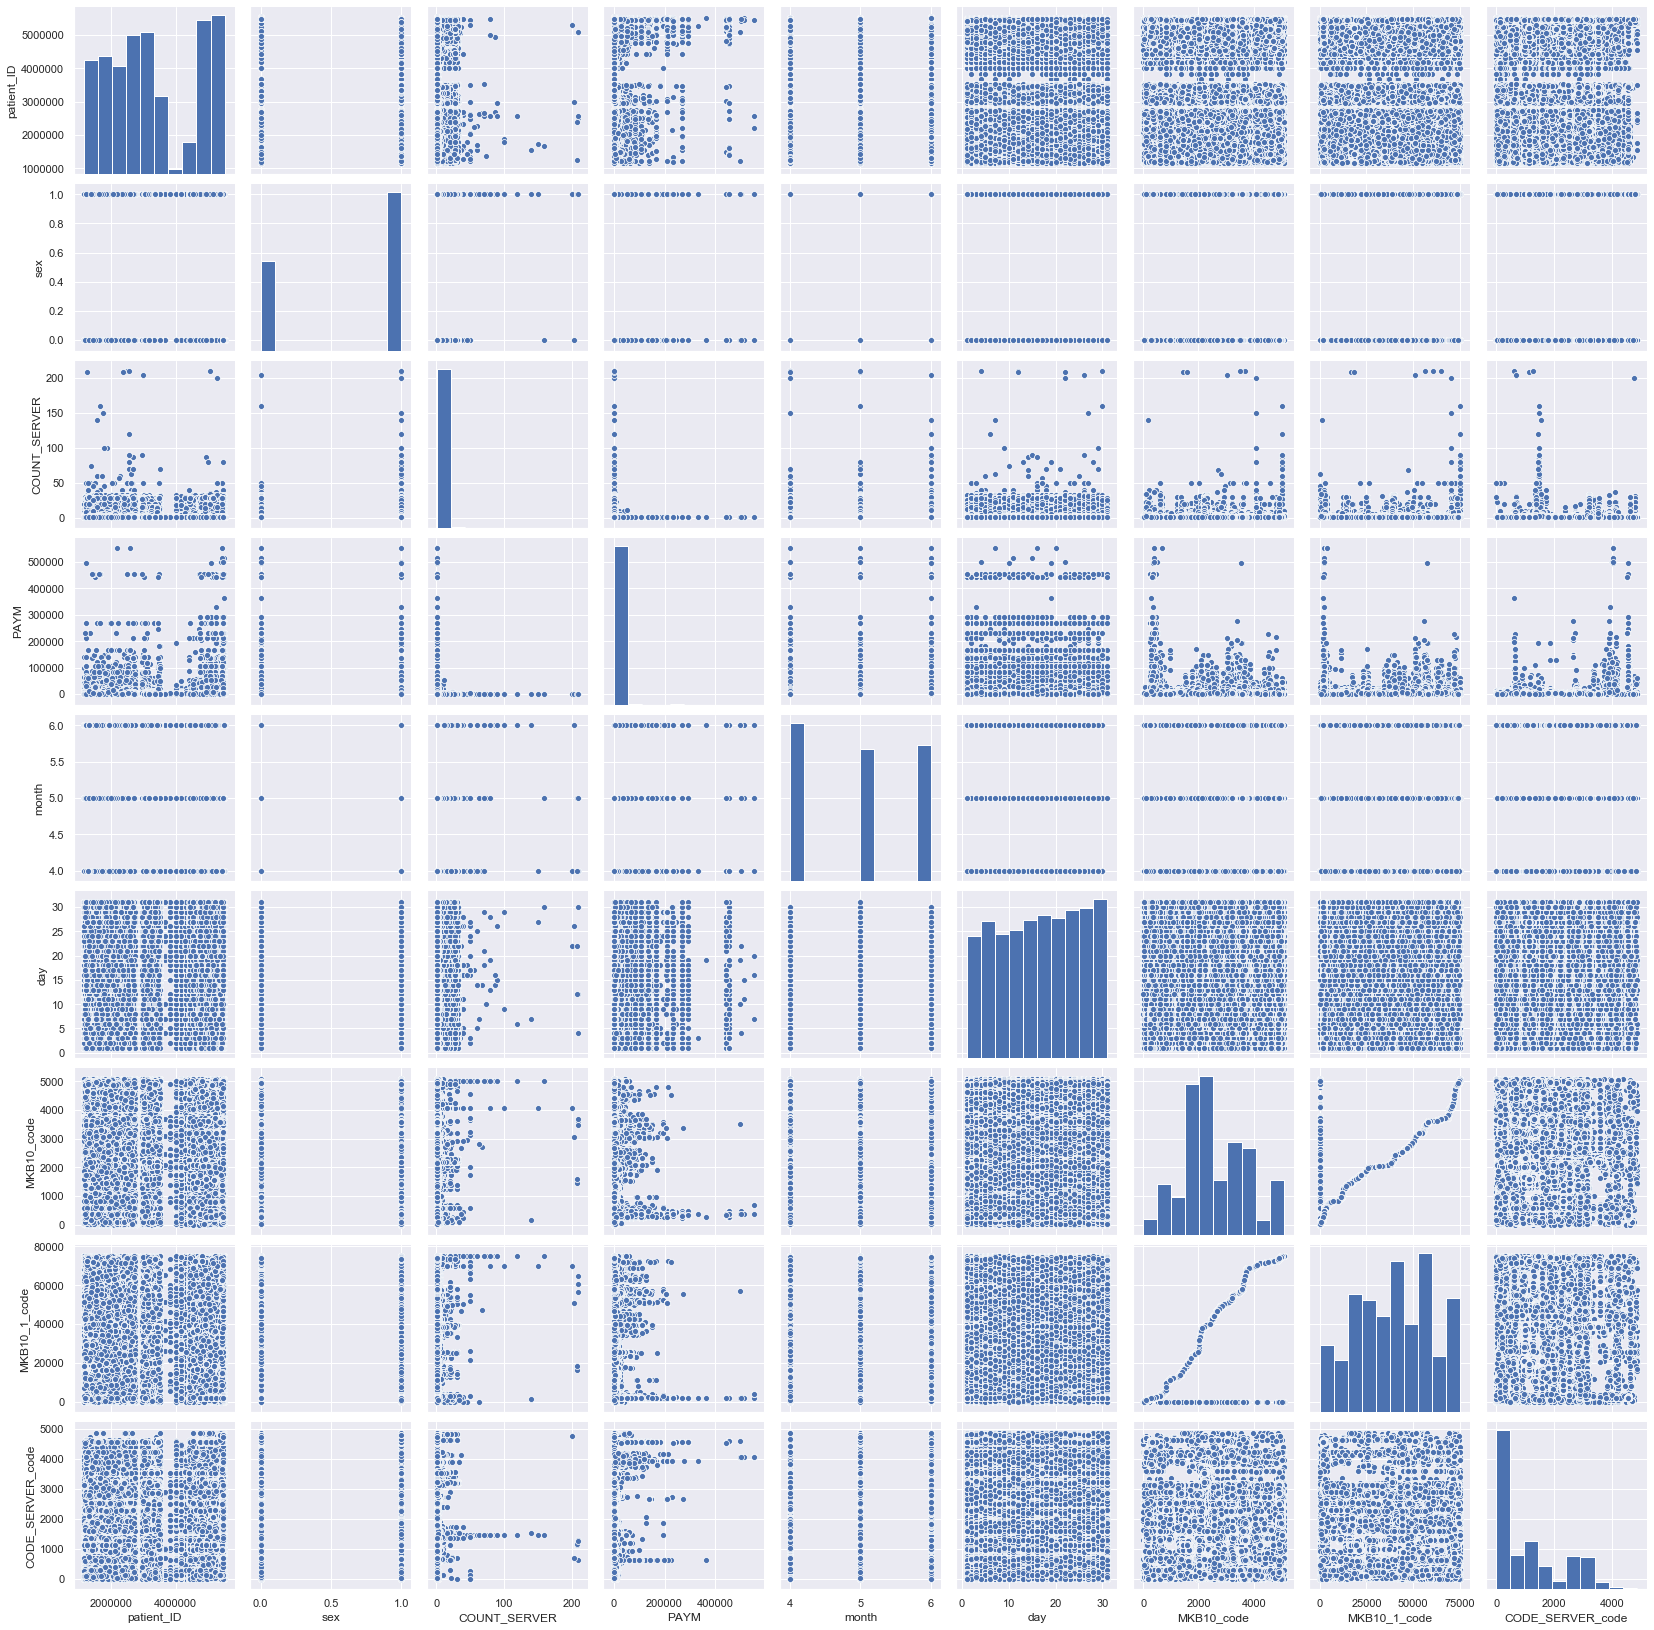

In [20]:
sns.pairplot(df)

# Отбор признаков

## Построим линейную регруссию и выполним на ней прямой отбор признаков

In [21]:
X = df[[
    'patient_ID', 'sex', 'CODE_SERVER_code', 'COUNT_SERVER', 'month', 'day',
    'MKB10_code', 'MKB10_1_code'
]]
y = df[['PAYM']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [22]:
clf = LinearRegression(n_jobs=-1)

sfs1 = sfs(clf,
           k_features=4,
           forward=True,
           floating=False,
           verbose=2,
           scoring='r2',
           cv=5)
sfs1 = sfs1.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.1s finished

[2021-03-29 17:01:46] Features: 1/4 -- score: 0.01914469904122078[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s finished

[2021-03-29 17:01:49] Features: 2/4 -- score: 0.024635270671548935[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s finished

[2021-03-29 17:01:52] Features: 3/4 -- score: 0.026712807705484322[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

In [23]:
feat_cols = list(sfs1.k_feature_names_)
print(f'Самая лучшая модель отобрала признаки: {sfs1.k_feature_names_}')

Самая лучшая модель отобрала признаки: ('patient_ID', 'CODE_SERVER_code', 'COUNT_SERVER', 'MKB10_1_code')


In [24]:
X = df[feat_cols]
y = df[['PAYM']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Посмотрим матрицу корреляций

In [25]:
corr = X.corr(method='spearman')
corr

,patient_ID,CODE_SERVER_code,COUNT_SERVER,MKB10_1_code
patient_ID,1.000000,0.021443,0.001681,0.029470
CODE_SERVER_code,0.021443,1.000000,0.226840,-0.066849
COUNT_SERVER,0.001681,0.226840,1.000000,-0.004143
MKB10_1_code,0.029470,-0.066849,-0.004143,1.000000


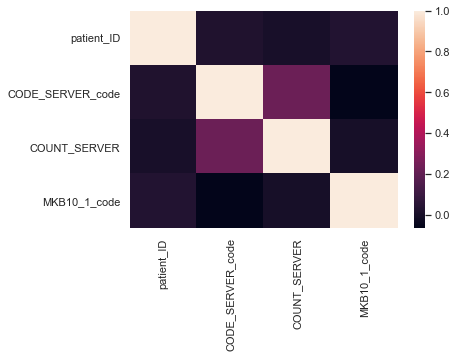

In [26]:
sns.heatmap(corr)

In [27]:
# Удалил все признаки, у которых корреляция больше 0.9
columns = np.full((corr.shape[0], ), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X = X[selected_columns]

# Выбор модели машиного обучения

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [29]:
models = [
    LinearRegression(n_jobs=-1),
    RandomForestRegressor(n_estimators=50, max_features='sqrt', n_jobs=-1),
    KNeighborsRegressor(n_neighbors=6, n_jobs=-1),
    xgb.XGBRegressor(),
]

In [30]:
TestModel = pd.DataFrame()
tmp = {}

for model in models:
    m = str(model)
    model.fit(X_train, y_train)

    tmp['Model'] = m[:m.index('(')]
    tmp['R^2_test'] = r2_score(y_test, model.predict(X_test))
    tmp['R^2_train'] = r2_score(y_train, model.predict(X_train))

    TestModel = TestModel.append([tmp])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [31]:
TestModel = TestModel.set_index(['Model'])

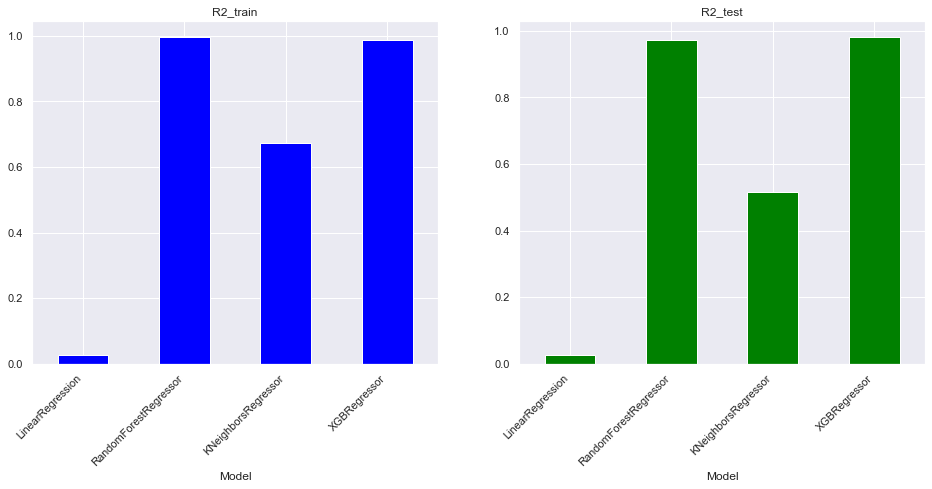

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 7))

TestModel['R^2_train'].plot(ax=axes[0], kind='bar', title='R2_train', color='blue')
TestModel['R^2_test'].plot(ax=axes[1], kind='bar', title='R2_test', color='green')
fig.autofmt_xdate(rotation=45)

## Построение модели и обучение

In [33]:
modelXGB = xgb.XGBRegressor()

### Выбор гиперпараметров модели

In [34]:
reg_cv = GridSearchCV(modelXGB, {
    "colsample_bytree": [1.0],
    "min_child_weight": [1.0, 1.2],
    'max_depth': [3, 4, 6],
    'n_estimators': [30, 100]
},
                      verbose=1,
                      n_jobs=-1)

In [35]:
reg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_est...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=Non

In [36]:
gbm = xgb.XGBRegressor(**reg_cv.best_params_)
gbm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1.2, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=6, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [38]:
print(f'Точность на тестовом наборе: {r2_score(y_test, gbm.predict(X_test))}')
print(f'Точность на тренировочном наборе: {r2_score(y_train, gbm.predict(X_train))}')

Точность на тестовом наборе: 0.9803634359417404
Точность на тренировочном наборе: 0.9861941758522282


In [39]:
y_pred = gbm.predict(X_test)

## Отобразим первые 100 испытаний

In [40]:
df_plots = pd.DataFrame({'Actual': np.array(y_test[:100].values.ravel()),
                       'Predict': np.array(y_pred[:100])})

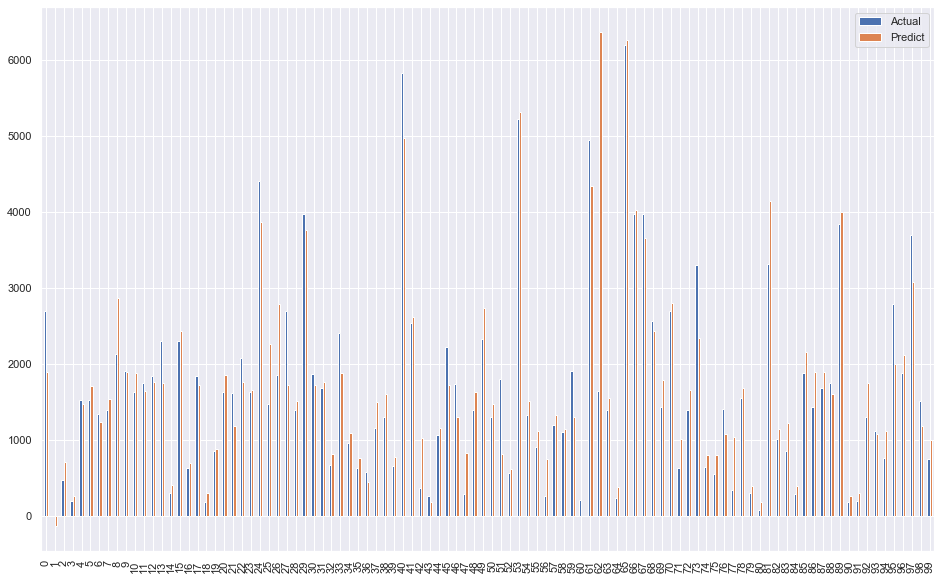

In [41]:
df_plots.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='1')
plt.grid(which='minor', linestyle=':', linewidth='1')#, color='black')
plt.show()

## Предсказанное значение

In [42]:
y_pred.sum()

1225021300.0